In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import xarray as xr

fig_set = {
    "axes.linewidth": .5,
    "axes.labelsize": 10,
    "axes.labelpad": 4.0,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.minor.size": 2,
    "xtick.minor.width" : 0.5,
    "ytick.minor.size": 2,
    "ytick.minor.width" : 0.5,
    "xtick.minor.visible" : True,
    "ytick.minor.visible" : True,
    "xtick.minor.visible" : True,
    "ytick.minor.visible" : True,
    "xtick.top" : True,
    "ytick.right" : True,
    "font.size": 10,
    "font.family": 'sans-serif',
    "xtick.direction": 'in', 
    "ytick.direction": 'in' 
}
plt.rcParams.update(fig_set)


nxw = 1280
nyw = 1
nnx = 2*nxw+1
nny = 2*nyw+1
nx = nxw
ny  = int(nyw/3)*2
print("ny=",ny)

global_nz = 64
nprocz_mpi = 32
nprocz = 1
nzero = nny - (ny+ny+1)  

nz = int(global_nz / nprocz_mpi)
print("nz=",nz)

size = 8 + ( 16*(2*nx+1)*(ny+1)*(2*nz) ) 
size_timestep = size + 4*2               
file_size = os.path.getsize('../lin_dipole/data/Fld/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g0000.mag.001')

nt = int(file_size/size_timestep)
print("nt=",nt)

ny= 0
nz= 2
nt= 2


In [2]:
grid = np.zeros( ( 2*nz*nprocz_mpi , nnx, 6 ), dtype="float32")
for inp in range(0,nprocz_mpi):
    data_npz = np.loadtxt("../lin_dipole/data/Grid/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g{:0=4}.grid.001".format(inp)).reshape(2*nz, 2*nx+1, 8)
    grid[ inp*2*nz: (inp+1)*2*nz , : , 0] = data_npz[:,:,0]   # r
    grid[ inp*2*nz: (inp+1)*2*nz , : , 1] = data_npz[:,:,1]   # theta
    grid[ inp*2*nz: (inp+1)*2*nz , : , 2] = data_npz[:,:,6]   # xi1
    grid[ inp*2*nz: (inp+1)*2*nz , : , 3] = data_npz[:,:,7]   # xi3
    grid[ inp*2*nz: (inp+1)*2*nz , : , 4] = data_npz[:,:,2]   # b0
    grid[ inp*2*nz: (inp+1)*2*nz , : , 5] = data_npz[:,:,5]   # h3
    
x = grid[:,:,0]*np.sin(grid[:,:,1])
z = grid[:,:,0]*np.cos(grid[:,:,1])

In [3]:
def read_binary(ip,it):
    f = open("../lin_dipole/data/Fld/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g{:0=4}.mag.001".format(ip))
    f.seek(it*(size+4*2))
    header = np.fromfile(f, dtype= np.int32, count=1 )
    t = np.fromfile(f, dtype= np.float64, count=1)
    wcpr = np.fromfile(f, dtype = np.complex128, count= (2*nx+1)*(ny+1)*(2*nz) ).reshape(2*nz, ny+1, 2*nx+1)
    footer = np.fromfile(f, dtype= np.int32, count=1 )
    f.close()
    return t, wcpr

def mag_cpr(inp,it):
    for iz in range(0,inp):
        t, wcpr = read_binary(iz,it)
        data_inp = np.loadtxt("../lin_dipole/data/Grid/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g{:0=4}.grid.001".format(iz)).reshape(2*nz, 2*nx+1, 8)
        b0 = data_inp[:,:,2]
        t = t[0]
        wcpr = wcpr
        func_main_at_t = np.array( wcpr )
        if (iz==0) :
            func = func_main_at_t
        else:
            func = np.concatenate([func,func_main_at_t], axis=0 )
    return t, func[:,0,:]

1200.0039999992712


/var/folders/ly/ckthzb2962sd5kp9d7llrl_m0000gn/T/ipykernel_74102/1699310833.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad = ax.pcolormesh(xf,zf,np.real(cprf[:,:]) , shading="auto")


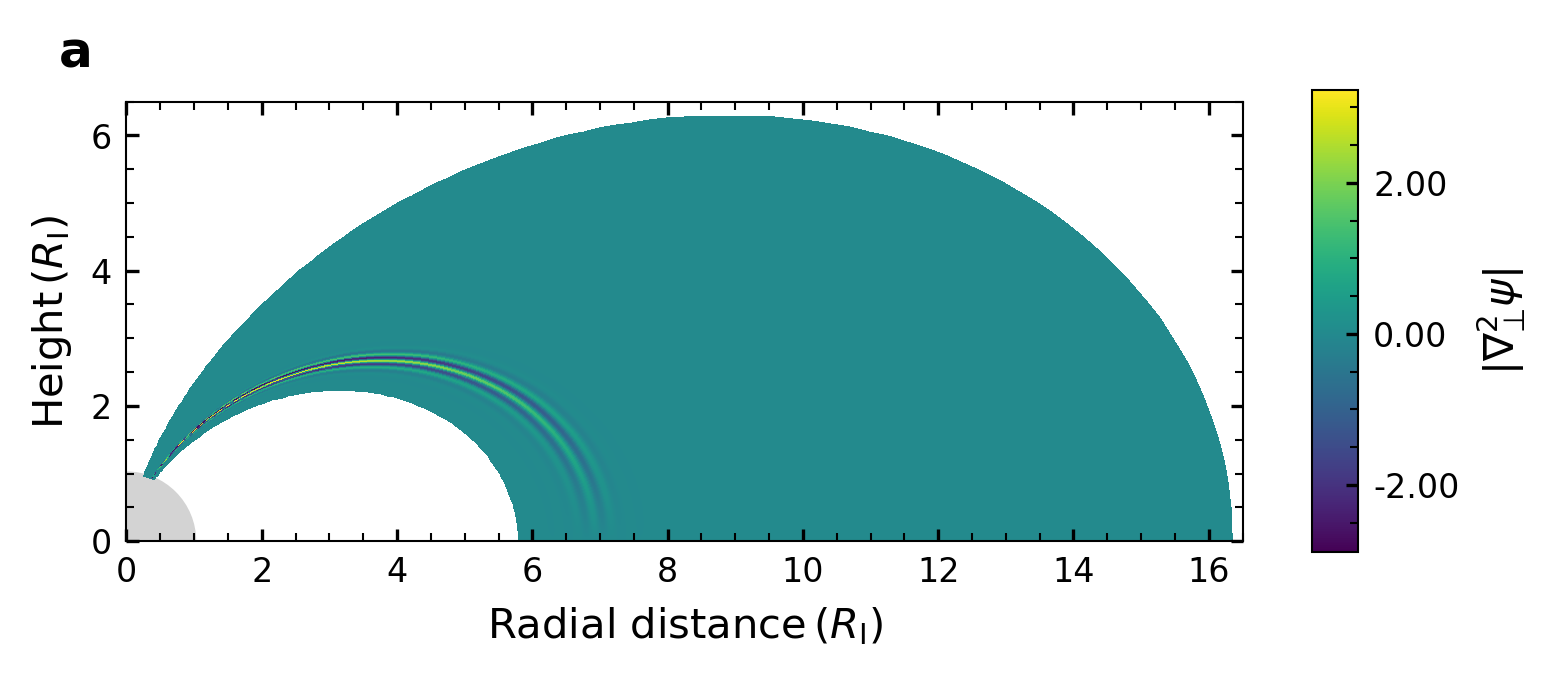

In [4]:
# full distribution of j
t, cpr = mag_cpr(nprocz_mpi, 1)
print(t)
xg = 1/grid[0,:,2].reshape(1,len(x[0,:]))
zg = np.zeros((len(x[0,:])), dtype="float64").reshape(1,len(x[0,:]))
cprg = np.zeros((len(x[0,:])), dtype="complex128").reshape(1,len(x[0,:]))
xf = np.concatenate([x,xg],axis=0)
zf = np.concatenate([z,zg],axis=0)
cprf = np.concatenate([cpr,cprg], axis=0)

dpi = 300
fig, ax= plt.subplots(figsize=(6,2), dpi=dpi)
draw_circle = plt.Circle((0, 0), 1.0, color = "lightgray")
ax.set_aspect(1)
ax.add_artist(draw_circle)
quad = ax.pcolormesh(xf,zf,np.real(cprf[:,:]) , shading="auto")
cbar = fig.colorbar( quad , shrink=1.0, aspect=10.0, format="%0.2f")
cbar.set_label(r"$|\nabla^2_\bot\psi|$")
ax.set_xlim(0,16.5)
ax.set_ylim(0,6.5)
ax.set_xlabel("Radial distance$\,(R_\mathrm{I})$")
ax.set_ylabel("Height$\,(R_\mathrm{I})$")
ax.text(-1., 7, "a", fontfamily="sans-serif", fontweight="bold", fontsize=12)
plt.savefig("../fig3-6/fig_sub/fig3a.png", bbox_inches='tight')